# Gradient Boosting Machines

In [1]:
!pip install jovian opendatasets xgboost graphviz lightgbm scikit-learn xgboost lightgbm --upgrade --quiet

In [2]:
!pip install numpy pandas-profiling matplotlib seaborn --quiet

## Problem Statement
To forcast sale for a store.
## Download Data

In [1]:
import os
import opendatasets as od
import pandas as pd
pd.set_option("display.max_columns", 120)
pd.set_option("display.max_rows", 120)

In [2]:
od.download('https://www.kaggle.com/c/rossmann-store-sales')

Skipping, found downloaded files in ".\rossmann-store-sales" (use force=True to force download)


In [3]:
os.listdir('rossmann-store-sales')

['sample_submission.csv', 'store.csv', 'test.csv', 'train.csv']

In [4]:
ross_df = pd.read_csv('./rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
test_df = pd.read_csv('./rossmann-store-sales/test.csv')
submission_df = pd.read_csv('./rossmann-store-sales/sample_submission.csv')

In [5]:
ross_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [6]:
test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0


In [7]:
submission_df

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
41083,41084,0
41084,41085,0
41085,41086,0
41086,41087,0


In [8]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


store_df is supplemental information about the stores. Hence, merge store_df to train_df and test_df.

In [9]:
merged_df = ross_df.merge(store_df, how='left', on='Store')
merged_test_df = test_df.merge(store_df, how='left', on='Store')

In [10]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [11]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

Do exploratory data analysis and visualization on the dataset:

In [12]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [ ]:
sns.violinplot(data=merged_df, x='DayOfWeek', y='Sales', title='Day of week v.s. Sales')

In [ ]:
px.histogram(merged_df[merged_df.Sales != 0], x='Sales', color='DayOfWeek', title='Day of week v.s. have Sales')

See that day of week with sales seems evenly distributed with 6 days (without 7)

In [ ]:
px.histogram(merged_df[merged_df.Sales == 0], x='DayOfWeek', title='Day of week v.s. not have Sales')

In [42]:
sun_df = merged_df[merged_df.DayOfWeek == 7]
print(f'On Sunday, have sales (>0) is '
      f'{round(sun_df[sun_df.Sales != 0].shape[0] / sun_df.shape[0] * 100, 2)} %')

On Sunday, have sales (>0) is 2.48 %


See on sunday, it is usually have no sales.

In [ ]:
px.scatter(merged_df.sample(2000),
           title='Date v.s. Sales',
           x='Date',
           y='Sales')

See that on paticular date may reasonable to predict sales (0 or high sales). However, in general it seems not highly correlated.

In [ ]:
px.scatter(merged_df, x='Sales', y='Customers', title='Customers v.s. Sales')

The plot shows that there seems have a relationship between Sales and Customers.

In [ ]:
sns.violinplot(data=merged_df, x='Open', y='DayOfWeek', title='Customers v.s. Sales')

See that Open is highly correlated with DayOfWeek.

In [ ]:
px.box(merged_df, x='Promo', y='Sales')

See that average sales will be higher if there is a promotion.

In [ ]:
px.box(merged_df, x='Promo2', y='Sales')

However, continuing promotion seems does not high related with Sales.

In [ ]:
sns.violinplot(data=merged_df, x='StateHoliday', y='Sales')

Seems holiday leads to low Sales:

In [62]:
holiday_df = merged_df[merged_df.StateHoliday != '0']
print(f'The proportion of store open on State Holiday: '
      f'{round(holiday_df[holiday_df.Open == 1].shape[0] / holiday_df.shape[0] * 100, 2)}%')

The proportion of store open on State Holiday: 2.93%


Hence, low Sales on State Holiday maybe is the reason that store not open that day.

In [ ]:
holiday_open_df = holiday_df[holiday_df.Open == 1]
sns.violinplot(data=holiday_open_df, x='StateHoliday', y='Sales')

Seems no huge difference between different holidays and non-holidays.

In [ ]:
sns.violinplot(data=merged_df, x='SchoolHoliday', y='Sales')

Seems no strong correlation between School Holiday and Sales.

In [ ]:
sns.violinplot(data=merged_df, x='StoreType', y='Sales')

Seems b type store are different to other three types.

In [ ]:
sns.violinplot(data=merged_df, x='Assortment', y='Sales')

b type is differnet to other 3.

In [73]:
print(f'correlation of competition distance and sales are: {merged_df.Sales.corr(merged_df.CompetitionDistance)}')

correlation of competition distance and sales are: -0.019229200503111124


See low negative correlation.
## Preprocessing and Feature Enginerring

In [13]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

### Date

In [14]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = df.Date.dt.isocalendar().week

In [15]:
split_date(merged_df)
split_date(merged_test_df)

In [16]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013,1,1,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1


### Store Open

In [17]:
merged_df[merged_df.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

In [18]:
merged_df = merged_df[merged_df.Open == 1].copy()

### Competition

In [19]:
def comp_months(df):
    df['CompetitionOpen'] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x < 0 else x).fillna(0)

In [20]:
comp_months(merged_df)
comp_months(merged_test_df)

In [21]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,a,150.0,9.0,2006.0,0,NaN,NaN,NaN,2013,1,1,1,76.0
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,b,860.0,10.0,1999.0,0,NaN,NaN,NaN,2013,1,1,1,159.0
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,b,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",2013,1,1,1,0.0
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,b,1430.0,NaN,NaN,0,NaN,NaN,NaN,2013,1,1,1,0.0


In [22]:
merged_df[['Date', 'CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'CompetitionOpen']].sample(20)

,Date,CompetitionDistance,CompetitionOpenSinceYear,CompetitionOpenSinceMonth,CompetitionOpen
269890,2014-11-26,18020.0,NaN,NaN,0.0
951959,2013-02-28,3570.0,2007.0,4.0,70.0
189071,2015-02-12,9790.0,NaN,NaN,0.0
154985,2015-03-14,1270.0,2008.0,9.0,78.0
623952,2013-12-19,1590.0,NaN,NaN,0.0
124044,2015-04-11,18640.0,2013.0,9.0,19.0
335491,2014-09-16,570.0,2007.0,11.0,82.0
962519,2013-02-19,3430.0,NaN,NaN,0.0
352613,2014-08-29,1500.0,2005.0,10.0,106.0
183611,2015-02-17,970.0,2013.0,3.0,23.0


### Promotion

In [23]:
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekOfYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [24]:
promo_cols(merged_df)
promo_cols(merged_test_df)

In [25]:
merged_df[['Date', 'Promo2', 'Promo2SinceYear', 'Promo2SinceWeek', 'PromoInterval', 'Promo2Open', 'IsPromo2Month']].sample(20)

,Date,Promo2,Promo2SinceYear,Promo2SinceWeek,PromoInterval,Promo2Open,IsPromo2Month
933889,2013-03-16,1,2013.0,31.0,"Mar,Jun,Sept,Dec",0.000000,0
25664,2015-07-08,1,2014.0,40.0,"Jan,Apr,Jul,Oct",9.245902,1
253853,2014-12-13,0,NaN,NaN,NaN,0.000000,0
67873,2015-06-01,1,2014.0,40.0,"Jan,Apr,Jul,Oct",8.098361,0
881469,2013-05-02,0,NaN,NaN,NaN,0.000000,0
614386,2013-12-28,0,NaN,NaN,NaN,0.000000,0
542107,2014-03-03,1,2013.0,27.0,"Jan,Apr,Jul,Oct",8.098361,0
544176,2014-03-01,0,NaN,NaN,NaN,0.000000,0
820596,2013-06-26,0,NaN,NaN,NaN,0.000000,0
701566,2013-10-11,0,NaN,NaN,NaN,0.000000,0


### x and y

In [26]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [27]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday',
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen',
              'Day', 'Month', 'Year', 'WeekOfYear',  'Promo2',
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'

In [28]:
inputs = merged_df[input_cols].copy()
targets = merged_df[target_col].copy()

In [29]:
test_inputs = merged_test_df[input_cols].copy()

In [30]:
numeric_cols = ['Store', 'Promo', 'SchoolHoliday',
                'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
                'Day', 'Month', 'Year', 'WeekOfYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [31]:
max_distance = inputs.CompetitionDistance.max()

In [32]:
inputs['CompetitionDistance'].fillna(max_distance, inplace=True)
test_inputs['CompetitionDistance'].fillna(max_distance, inplace=True)

### Scale Numeric Columns

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
scaler = MinMaxScaler().fit(inputs[numeric_cols])

In [35]:
inputs[numeric_cols] = scaler.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### Encode Categorical Column

In [36]:
from sklearn.preprocessing import OneHotEncoder

In [37]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

C:\Users\Little Mega\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [38]:
inputs[encoded_cols] = encoder.transform(inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [39]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

## Gradient Boosting
1. Make average value of the target column as prediction
2. Calculate the residuals
3. Train Decision Tree (limited depth) to predict residuals
4. Use learning rate to scale the predictions
5. Add to previous model to new predictions
6. Repeate steps 2 to 5

### Training

In [40]:
from xgboost import XGBRegressor

In [41]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [42]:
%%time
model.fit(X, targets)

Wall time: 1.94 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=20, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

### Prediction

In [43]:
preds = model.predict(X)

In [44]:
preds

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

### Evaludation

In [45]:
from sklearn.metrics import mean_squared_error

def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [46]:
rmse(preds, targets)

2377.752008804669

### Visualization

In [47]:
import matplotlib.pyplot as plt
from xgboost import plot_tree
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 30,30

import graphviz

<AxesSubplot:>

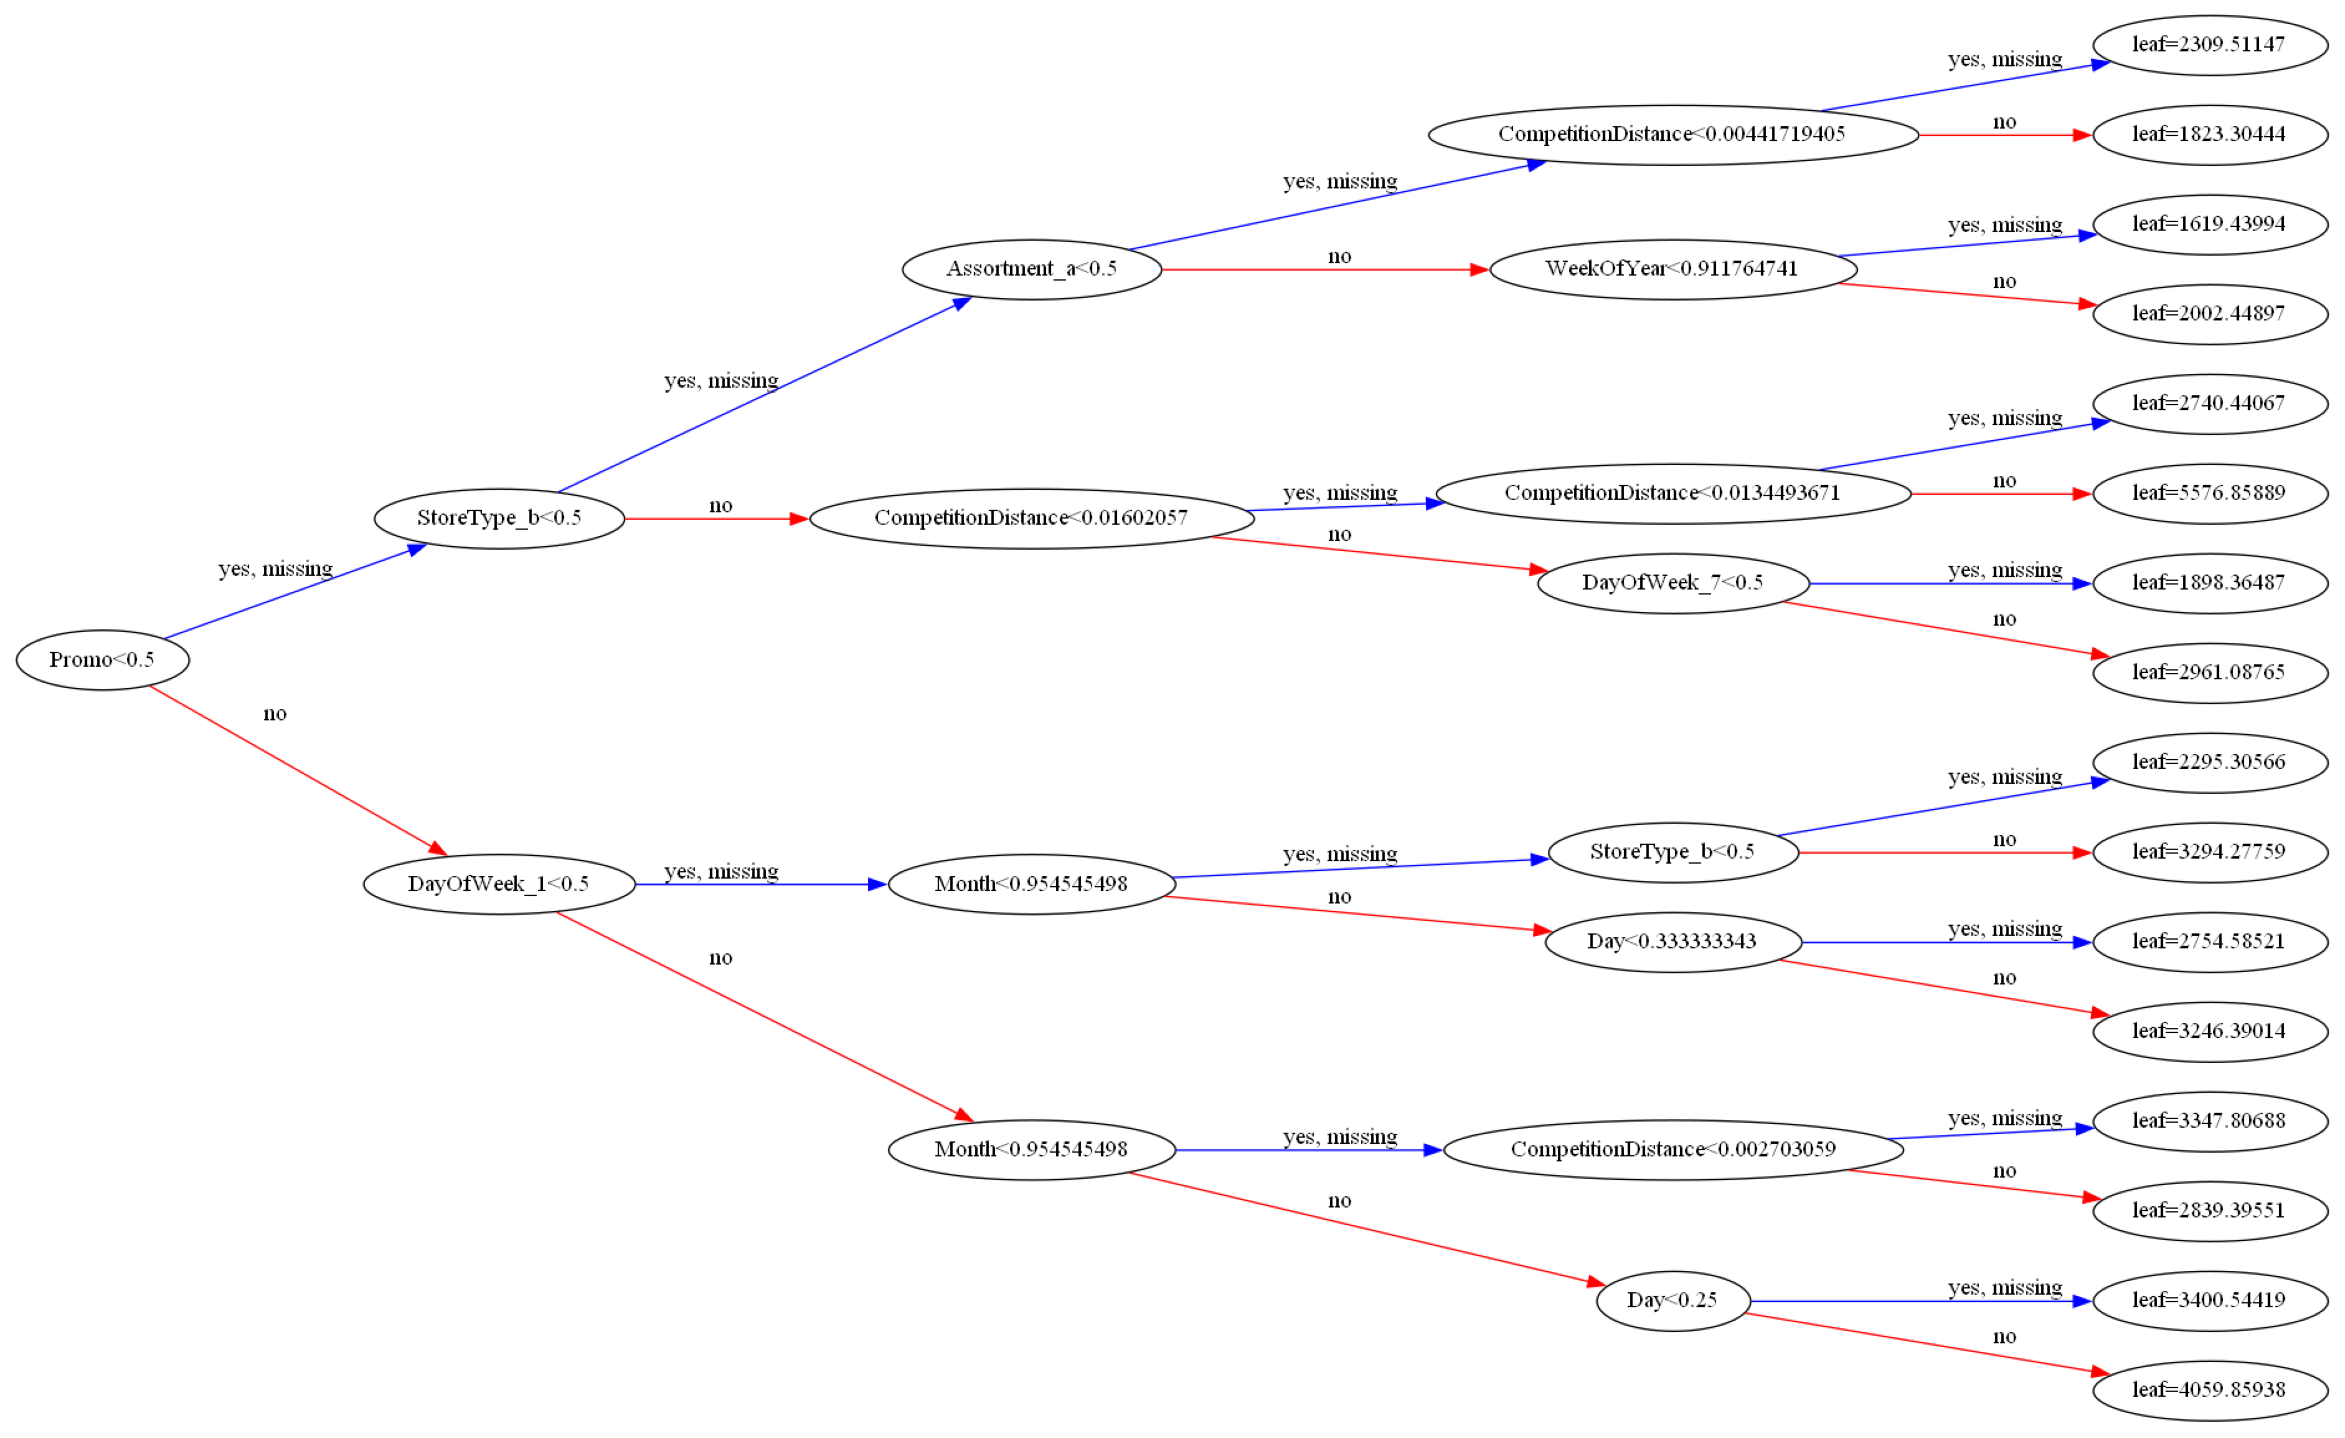

In [48]:
plot_tree(model, rankdir='LR')

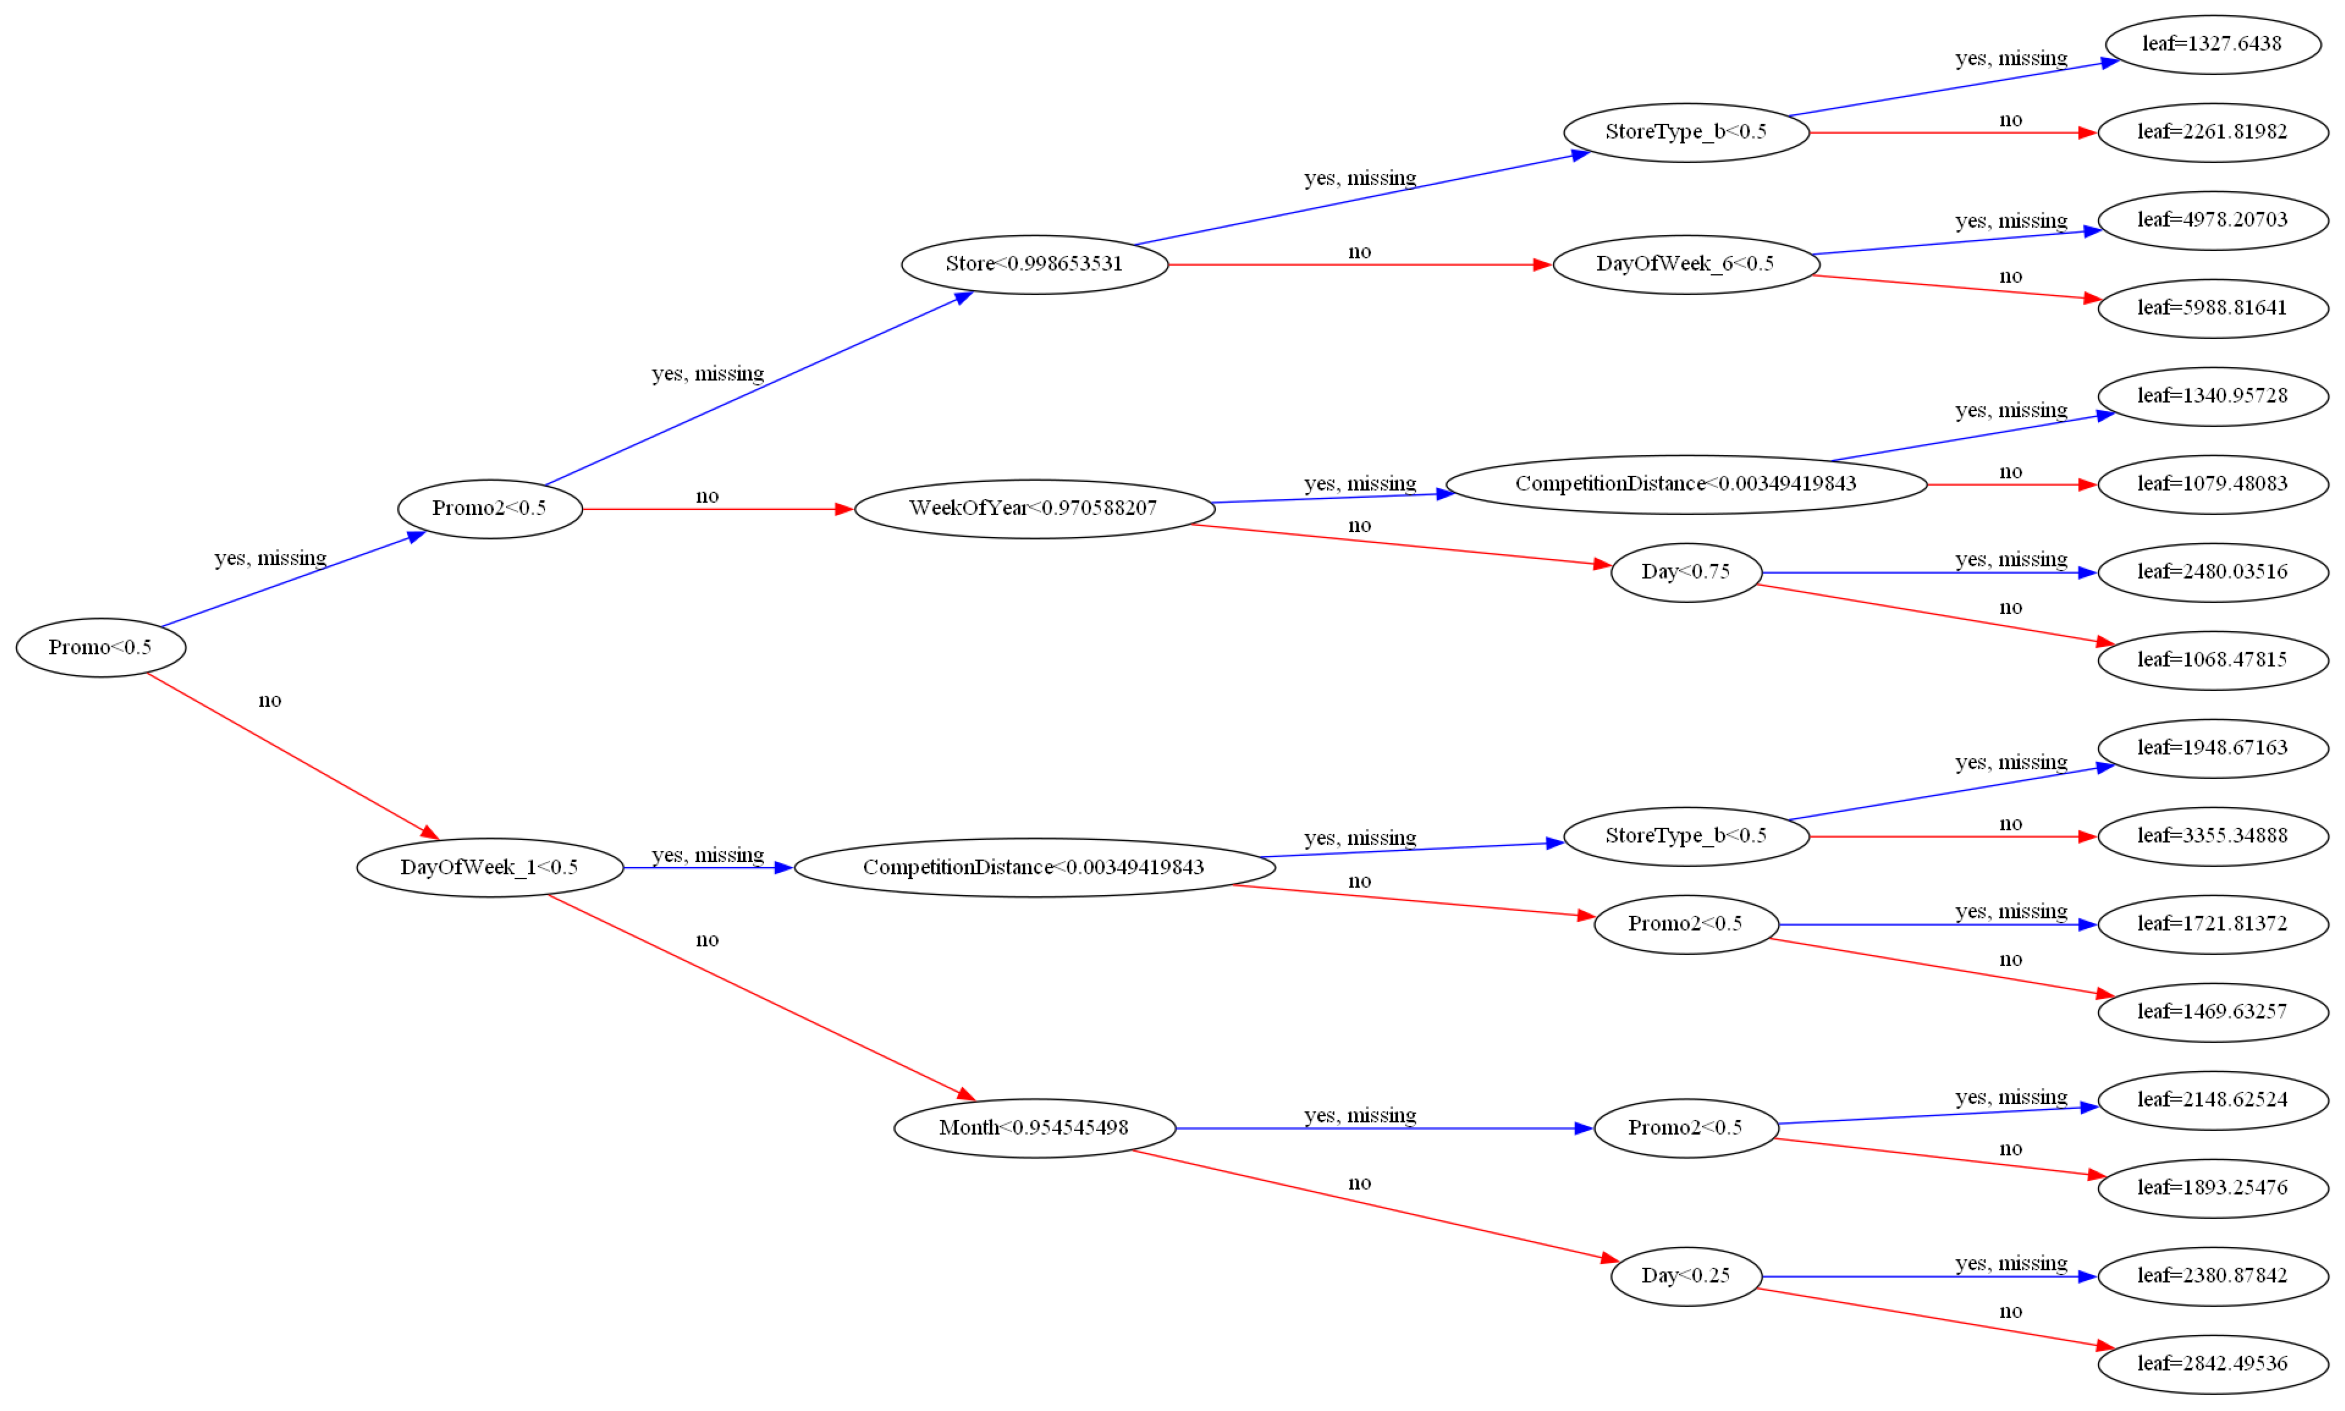

In [49]:
plot_tree(model, rankdir='LR', num_trees=1);

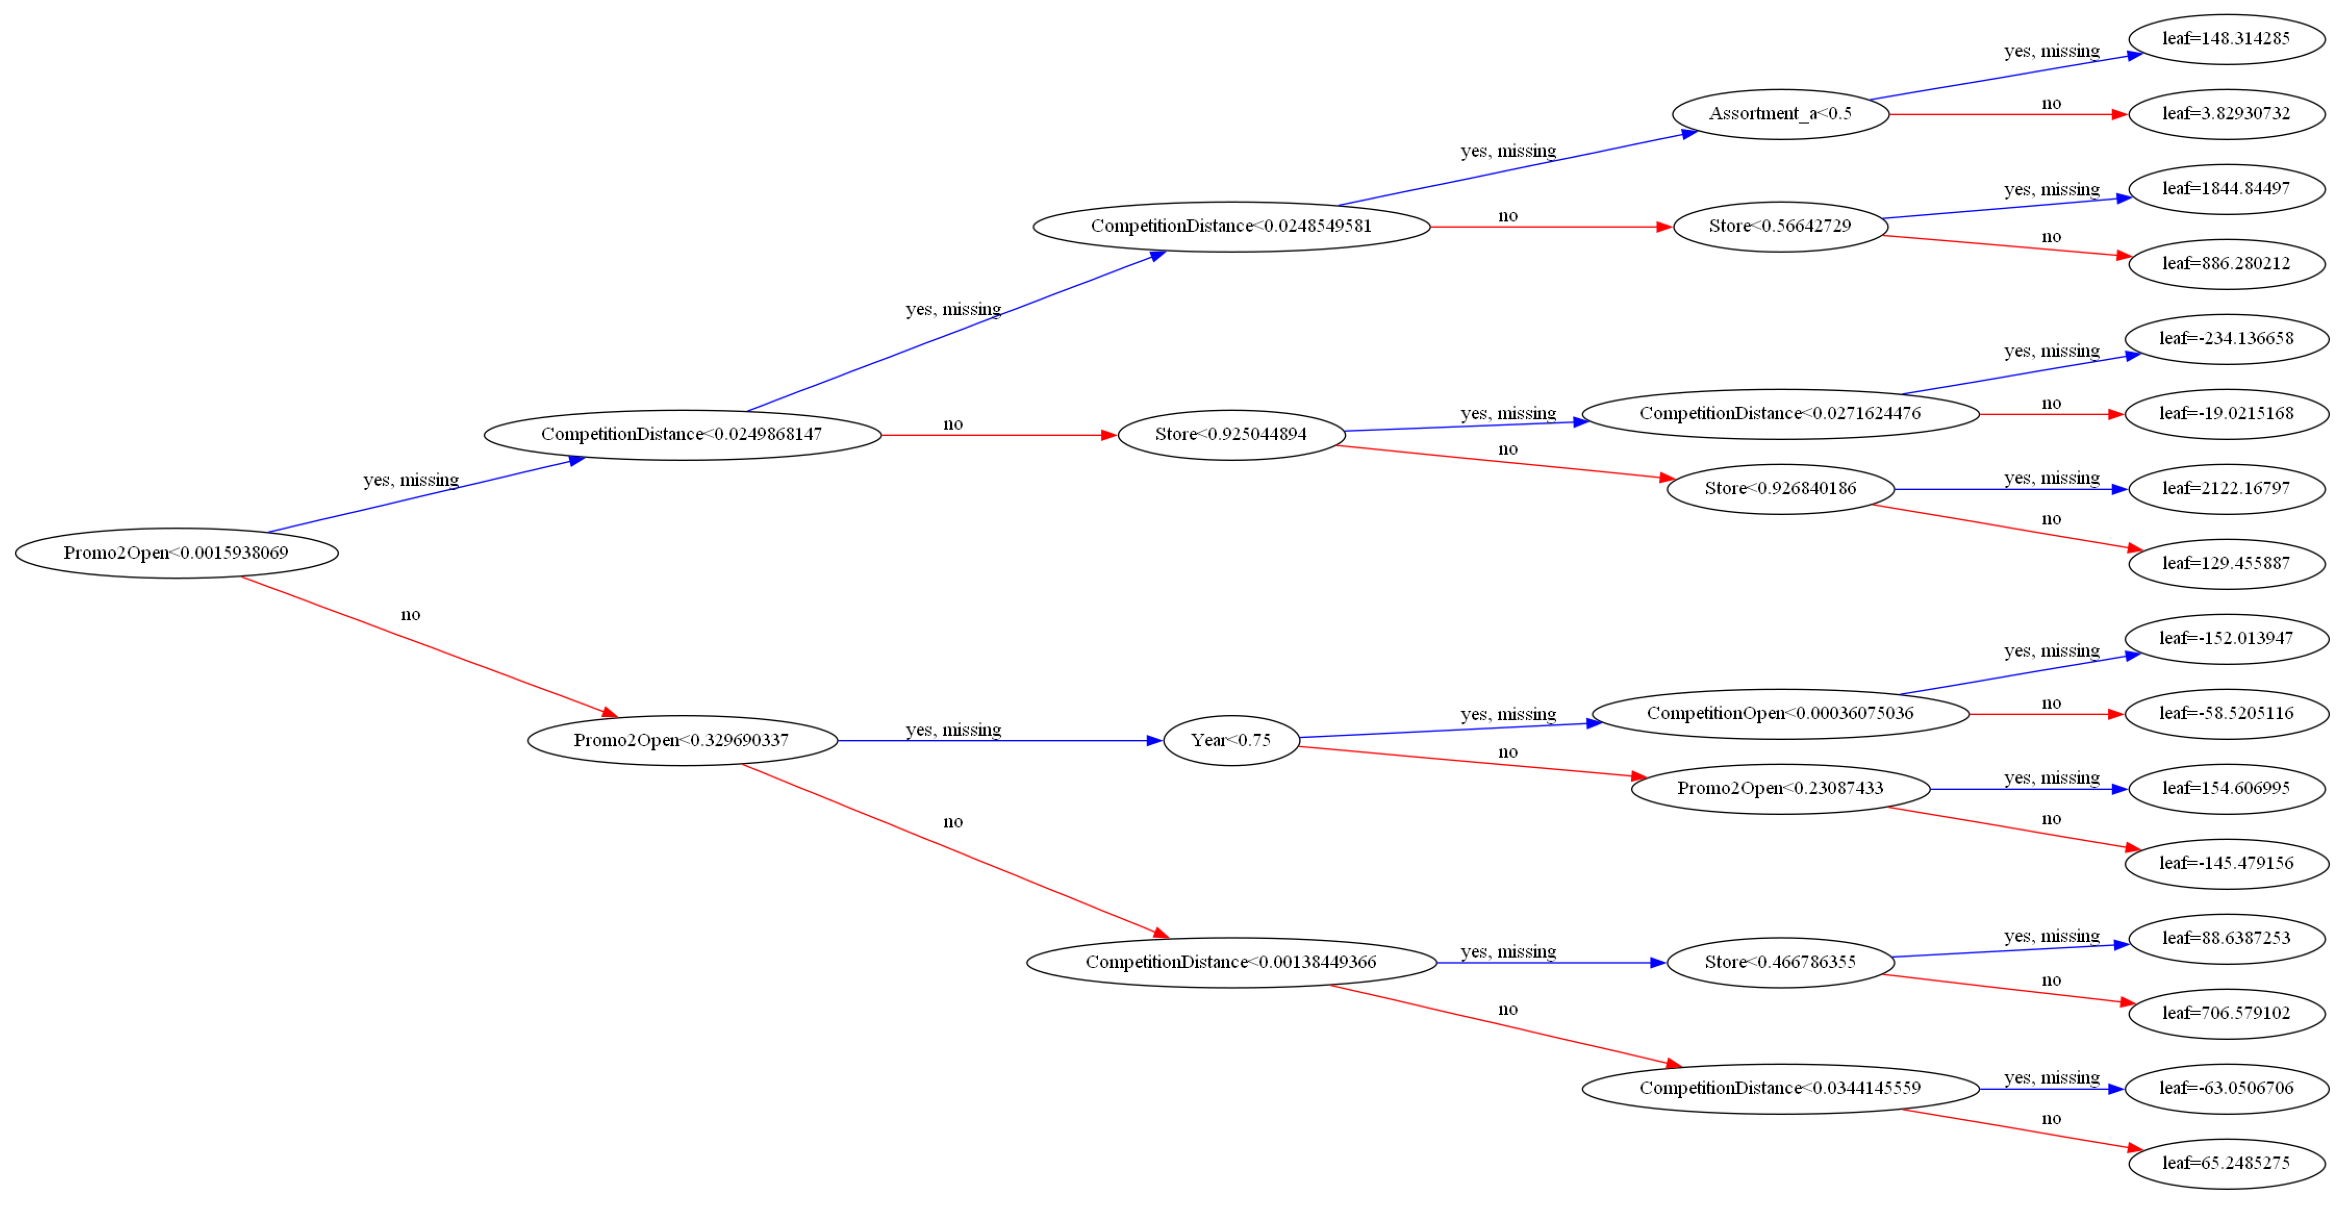

In [50]:
plot_tree(model, rankdir='LR', num_trees=19);

Note that tree compute residual instead of target value!

In [51]:
trees = model.get_booster().get_dump()

In [52]:
len(trees)

20

In [53]:
print(trees[0])

0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00441719405] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekOfYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.01602057] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.0134493671] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.002703059] yes=27,no=28,missing=27
				27:leaf=334

### Feature Importance

In [54]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

In [55]:
importance_df.head(10)

,feature,importance
1,Promo,0.317473
24,StoreType_b,0.086472
12,DayOfWeek_1,0.082268
5,Promo2,0.063986
3,CompetitionDistance,0.045053
29,Assortment_c,0.040226
27,Assortment_a,0.038759
9,Month,0.038493
0,Store,0.038119
8,Day,0.033209


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

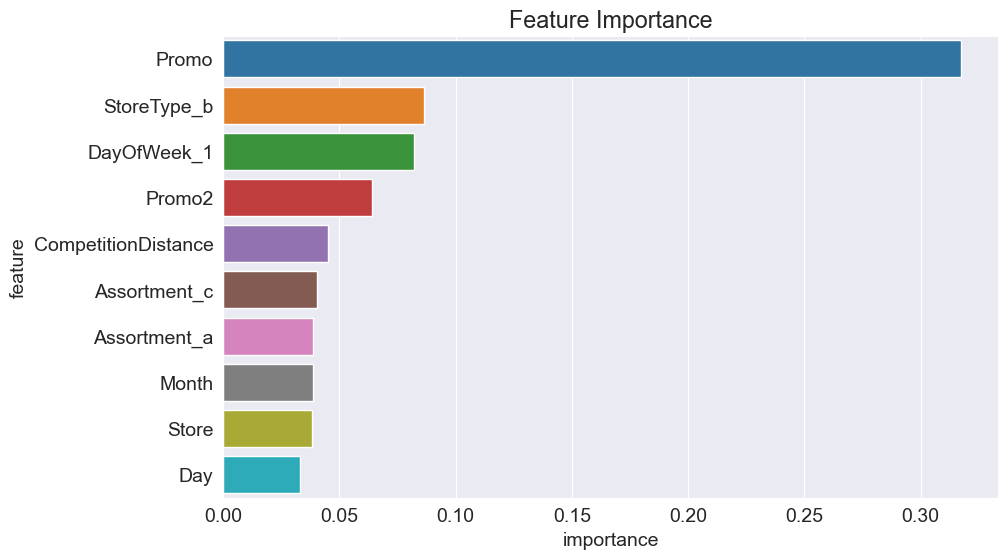

In [56]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

## Cross Validation

In [57]:
from sklearn.model_selection import KFold

In [58]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [59]:
kfold = KFold(n_splits=5)

models = []

for train_idxs, val_idxs in kfold.split(X):
    X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
    X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_train,
                                                     train_targets,
                                                     X_val,
                                                     val_targets,
                                                     max_depth=4,
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 2352.216448531526, Validation RMSE: 2424.6228916973314
Train RMSE: 2406.709513789309, Validation RMSE: 2451.9646038059277
Train RMSE: 2365.7354745443067, Validation RMSE: 2336.984157073758
Train RMSE: 2366.4732092777763, Validation RMSE: 2460.8995475901697
Train RMSE: 2379.3752997474626, Validation RMSE: 2440.665320626728


In [60]:
import numpy as np

def predict_avg(models, inputs):
    return np.mean([model.predict(inputs) for model in models], axis=0)

In [61]:
preds = predict_avg(models, X)

In [62]:
preds

array([8021.374 , 7577.715 , 8747.863 , ..., 7615.0303, 7924.784 ,
       9600.297 ], dtype=float32)

## Tuning Parameters

In [63]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

CV need long time to run, hence check with single validation set:

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_val, train_targets, val_targets = train_test_split(X, targets, test_size=0.1)

In [66]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

### n_estimators